In [1]:
# Team 42 - Notebook - June 22

In [3]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

     |████████████████████████████████| 4.1MB 2.7MB/s 
     |████████████████████████████████| 327kB 32.4MB/s 


In [6]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [5]:
# Modules from gecko.ipynb

import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
# Functions defined in gecko.ipynb

# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return

**Hackathon Challenges (Monday)**

1. Load the data
2. Create an exploratory visualization of the data
3. Test two different transformation and scaling methods
4. Test one dimensionality reduction method
5. Train a linear model
6. Train a decision tree ensemble method of your choice


In [14]:
# 1. Load the data

# Scripts adopted from gecko.ipynb

fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

test.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
28800,1.000000,0.069675,0.000000,0.000000,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28801,301.207794,0.068014,0.002547,0.000003,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28802,601.415588,0.066392,0.005037,0.000010,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28803,901.623352,0.064809,0.007463,0.000019,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28804,1201.831177,0.063264,0.009827,0.000030,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155


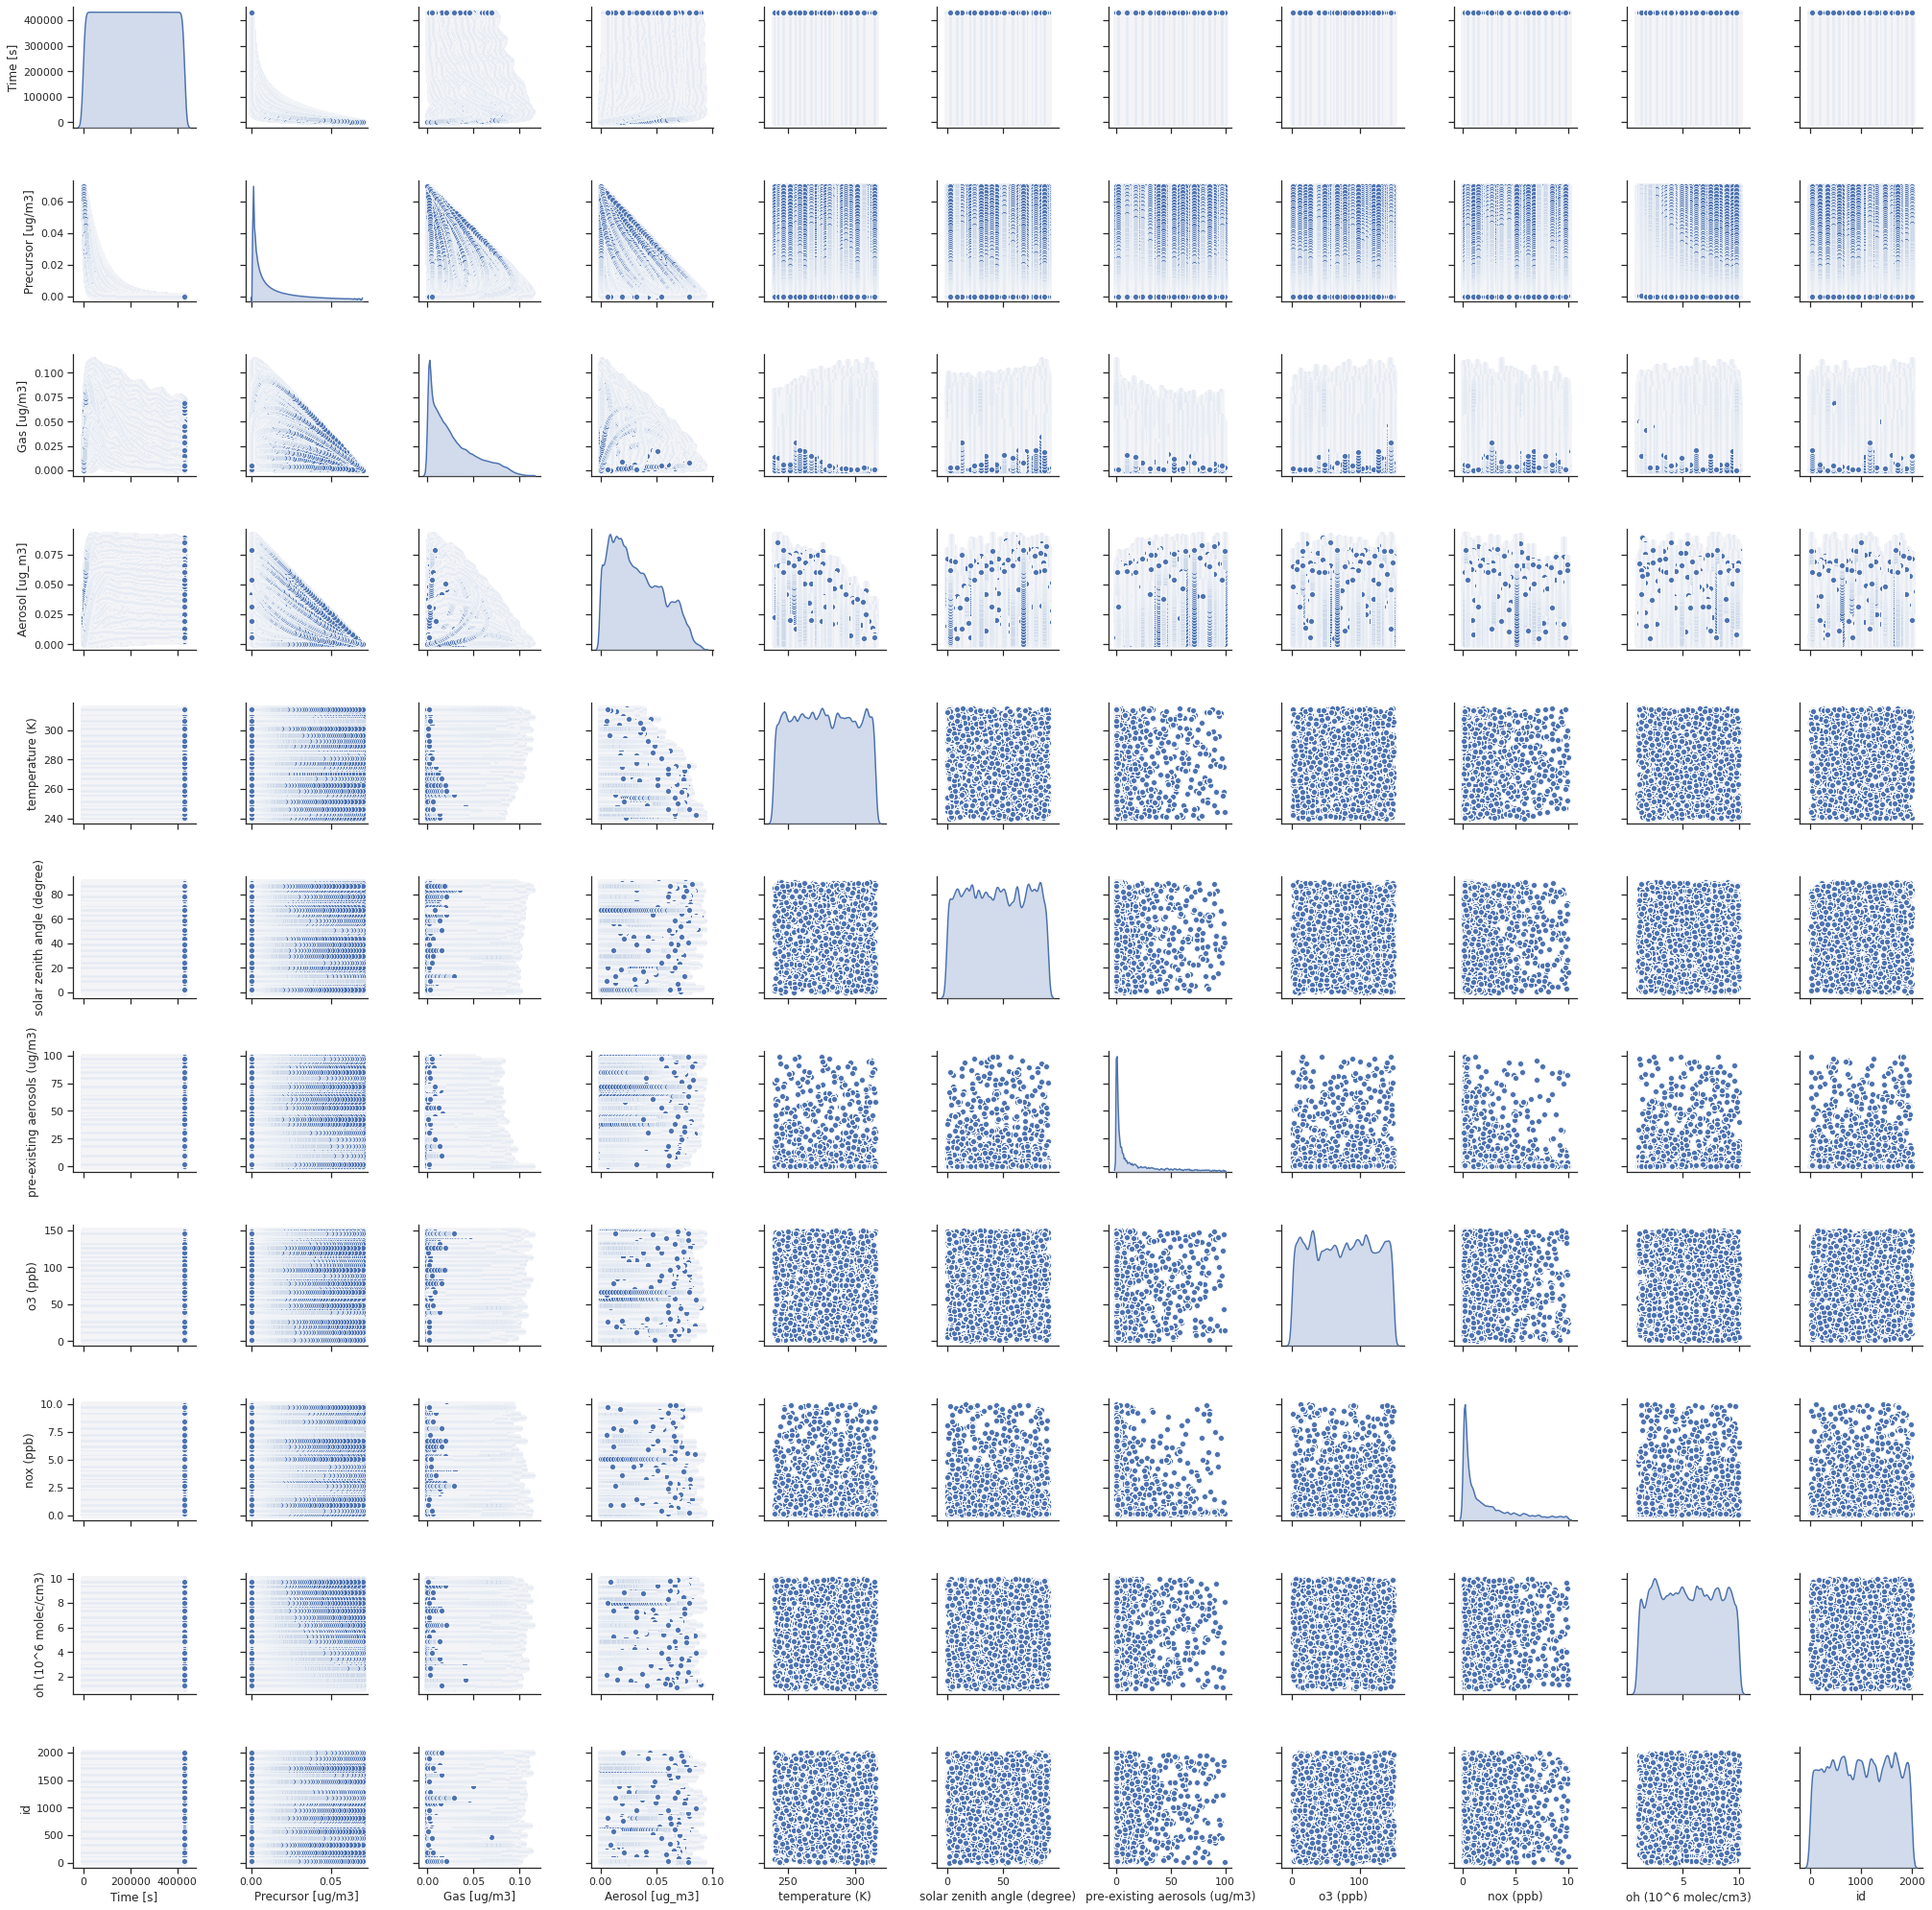

In [25]:
# 2. Create an exploratory visualization of the data

# EDV of training data.

sns.set(style="ticks")
sns.pairplot(train, diag_kind = 'kde')
plt.show()

# sns.savefig('gecko_EDV.png', format='png')

Standard Scaler
Mean : [ 6.26941491e-17  5.35332185e-16  1.37044588e-15 -2.22478936e-15
  1.07638819e-16 -3.97283814e-17 -6.61763741e-16  3.01586066e-16
  1.73251270e-16]
Std : [1.00000025 1.00000025 1.00000025 1.00000025 1.00000025 1.00000025
 1.00000025 1.00000025 1.00000025]

MinMax Scaler
Min : [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max : [1. 1. 1. 1. 1. 1. 1. 1. 1.]


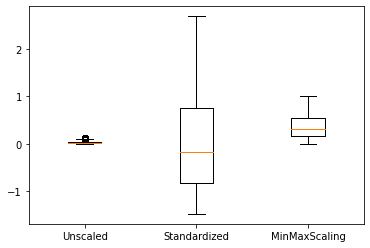

In [24]:
# 3. Test two different transformation and scaling methods

from scipy import stats

fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler1 = StandardScaler()
input_scaler2 = MinMaxScaler()

output_scaler1 = StandardScaler()
output_scaler2 = MinMaxScaler()


scaled_train_in1 = input_scaler1.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out1 = output_scaler1.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in1 = input_scaler1.transform(val_in.iloc[:,1:-1])
scaled_val_out1 = output_scaler1.transform(val_out.iloc[:,1:-1])

scaled_train_in2 = input_scaler2.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out2 = output_scaler2.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in2 = input_scaler2.transform(val_in.iloc[:,1:-1])
scaled_val_out2 = output_scaler2.transform(val_out.iloc[:,1:-1])

print("Standard Scaler")
print("Mean :", stats.describe(scaled_train_in1).mean)
print("Std :", np.sqrt(stats.describe(scaled_train_in1).variance))

print("\nMinMax Scaler")
print("Min :", stats.describe(scaled_train_in2).minmax[0])
print("Max :", stats.describe(scaled_train_in2).minmax[1])

# Visualization of the scaled data
results = [train_in.iloc[:, 2], scaled_train_in1[:, 2], scaled_train_in2[:, 2]]
labels = ['Unscaled', 'Standardized', 'MinMaxScaling']
plt.boxplot(results, labels=labels)
plt.show()

In [27]:
# 4. Test one dimensionality reduction method

# Here, MinMax-scaled training set will be used.
# Typically, dimensionality reduction is applied to the input of test data
# to drop some unnecessary features.

from sklearn.decomposition import PCA

print("Shape before dimensionality reduction:", scaled_train_in.shape)

pca = PCA(n_components=8, svd_solver="full")     # Drop one feature using Plain PCA
reduced_train_in = pca.fit(scaled_train_in)
reduced_train_in = pca.transform(scaled_train_in)
print("Shape after dimensionality reduction:", reduced_train_in.shape)
print("Explained variance :", pca.explained_variance_)
print("Explained variance ratio :", pca.explained_variance_ratio_ * 100)
print("Principal components :", pca.components_)

Shape before dimensionality reduction: (2015999, 9)
Shape after dimensionality reduction: (2015999, 8)
Explained variance : [0.12351142 0.09741838 0.08380108 0.07945435 0.06237065 0.05912461
 0.03119257 0.02149784]
Explained variance ratio : [21.78813373 17.18516995 14.78299759 14.01620976 11.00254625 10.42992495
  5.50255139  3.79234339]
Principal components : [[-0.09964282 -0.14509415  0.6052574  -0.65505337  0.17702034  0.17871125
   0.08931976 -0.01126993  0.31970084]
 [ 0.08064021  0.42949775 -0.0088121  -0.1583396   0.57695365 -0.09389683
   0.45638868 -0.02416565 -0.48302486]
 [ 0.04635546  0.04172884  0.06374691 -0.22997818  0.20730089 -0.01789917
  -0.84444077 -0.00403858 -0.42751104]
 [ 0.05688337  0.03383391  0.05975998 -0.38219291 -0.73012032  0.00737426
   0.19763102 -0.05637428 -0.5202026 ]
 [ 0.00288026 -0.01294961  0.01943186 -0.00591897 -0.01494577  0.09075149
   0.02716055  0.99270401 -0.06894357]
 [-0.06116975 -0.28137229  0.31932756  0.41716708  0.08237415  0.699485

In [33]:
# 5. Train a linear model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(scaled_train_in, scaled_train_out)

y_predict = model.predict(scaled_val_in)
print("Coefficients :", model.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(scaled_val_out, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(scaled_val_out, y_predict))

Coefficients : [[ 9.82453072e-01 -3.59586970e-03 -1.27992234e-03 -6.99624882e-04
   6.98947295e-04 -1.46663865e-05  4.27358466e-04 -4.87724008e-05
  -2.22097903e-03]
 [ 1.37924888e-02  9.98283666e-01  2.76045500e-04  1.01442915e-04
   2.31166072e-04 -4.55866097e-04  2.06788485e-04  1.40163531e-05
   9.07472062e-04]
 [ 3.26555399e-03  1.73299319e-03  9.99334801e-01 -2.85616258e-04
  -1.93387449e-04  6.67437657e-04 -1.82733005e-04 -1.83297712e-05
   7.34492651e-04]]
Mean squared error: 0.00
Coefficient of determination: 0.99


In [ ]:
# 6. Train a decision tree ensemble method of your choice

# It takes too much time to train the ensemble model, so the model was not fully trained.

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV     # Used to find optimal hyperparameters

# Random Forest Regressor

model = RandomForestRegressor(criterion="mse", bootstrap=True)
model.fit(scaled_train_in, scaled_train_out)
y_predict = model.predict(scaled_val_in)
model.score(scaled_val_in, y_predict)

# Gradient Boosting Regressor

model= GradientBoostingRegressor()
model.fit(scaled_train_in, scaled_train_out)
y_predict = model.predict(scaled_val_in)
model.score(scaled_val_in, y_predict)